In [1]:
from tensorflow import keras
import tensorflow
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras import optimizers, losses
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image

import pickle
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [3]:
data_dir = 'insects-recognition'

In [4]:
datagenerator = {
    "train": ImageDataGenerator(horizontal_flip=True,
                                vertical_flip=True,
                                rescale=1. / 255,
                                validation_split=0.1,
                                shear_range=0.1,
                                zoom_range=0.1,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                rotation_range=30,
                               ).flow_from_directory(directory=data_dir,
                                                     target_size=(300, 300),
                                                     subset='training',
                                                    ),

    "valid": ImageDataGenerator(rescale=1 / 255,
                                validation_split=0.1,
                               ).flow_from_directory(directory=data_dir,
                                                     target_size=(300, 300),
                                                     subset='validation',
                                                    ),
}

Found 10306 images belonging to 12 classes.
Found 1143 images belonging to 12 classes.


In [18]:
base_model = ResNet50V2(weights=None, include_top=False, input_shape=(300, 300, 3))

base_model.trainable = False

In [19]:
model = Sequential([
    base_model,
    Flatten(),
    Dense(200, activation=LeakyReLU(alpha=0.3)),
    Dense(100, activation=LeakyReLU(alpha=0.3)),
    
    Dropout(0.75),
    Dense(100, activation=LeakyReLU(alpha=0.3)),
    Dropout(0.5),
    Dense(12, activation='softmax')
])

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 10, 10, 2048)      23564800  
                                                                 
 flatten_1 (Flatten)         (None, 204800)            0         
                                                                 
 dense_4 (Dense)             (None, 200)               40960200  
                                                                 
 dense_5 (Dense)             (None, 100)               20100     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 dropout_1 (Dropout)         (None, 100)              

In [21]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

plt.savefig('ResNet50v2_b.png')

<Figure size 640x480 with 0 Axes>

In [5]:
base_model2 = tensorflow.keras.applications.ResNet50V2(weights = "imagenet",
                                                       input_shape = (300, 300, 3),
                                                       pooling = "max", include_top = False,
                                                       classes = 12)

for layer in base_model2.layers:
    layer.trainable = False

In [6]:
model2 = Sequential()
model2.add(base_model2)
model2.add(Flatten())

model2.add(Dense(128, activation = "relu"))
model2.add(Dense(64, activation = "relu"))
model2.add(Dense(32, activation = "relu"))
model2.add(Dense(12, activation = "softmax"))

# freeze the layers
for layer in base_model2.layers:
    layer.trainable = False
opt = optimizers.Adam(learning_rate=0.0001)

model2.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

In [7]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 12)                396       
                                                                 
Total params: 23,837,804
Trainable params: 273,004
Non-t

In [22]:
from keras.utils.vis_utils import plot_model
plot_model(model2, show_shapes=True, show_layer_names=True)
plt.savefig('ResNet50v2_2.png')

<Figure size 640x480 with 0 Axes>

In [9]:
batch_size = 32
epochs = 10

train_generator = datagenerator["train"]
valid_generator = datagenerator["valid"]

In [10]:
steps_per_epoch = train_generator.n // batch_size
validation_steps = valid_generator.n // batch_size

print("steps_per_epoch :", steps_per_epoch)
print("validation_steps :", validation_steps)

steps_per_epoch : 322
validation_steps : 35


In [11]:
filepath = "./model_ResNet50V2_{epoch:02d}-{val_accuracy:.2f}.h5"

checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint1]

history = model2.fit_generator(generator=train_generator, epochs=epochs, steps_per_epoch=steps_per_epoch,
                              validation_data=valid_generator, validation_steps=validation_steps,
                              callbacks=callbacks_list)

Epoch 1/10
322/322 [==============================] - ETA: 0s - loss: 2.0907 - accuracy: 0.3713
Epoch 1: val_accuracy improved from -inf to 0.61250, saving model to .\model_ResNet50V2_01-0.61.h5
322/322 [==============================] - 241s 717ms/step - loss: 2.0907 - accuracy: 0.3713 - val_loss: 1.1869 - val_accuracy: 0.6125
Epoch 2/10
322/322 [==============================] - ETA: 0s - loss: 1.0678 - accuracy: 0.6558
Epoch 2: val_accuracy improved from 0.61250 to 0.75089, saving model to .\model_ResNet50V2_02-0.75.h5
322/322 [==============================] - 207s 642ms/step - loss: 1.0678 - accuracy: 0.6558 - val_loss: 0.7663 - val_accuracy: 0.7509
Epoch 3/10
322/322 [==============================] - ETA: 0s - loss: 0.7863 - accuracy: 0.7509
Epoch 3: val_accuracy improved from 0.75089 to 0.80536, saving model to .\model_ResNet50V2_03-0.81.h5
322/322 [==============================] - 204s 633ms/step - loss: 0.7863 - accuracy: 0.7509 - val_loss: 0.6324 - val_accuracy: 0.8054
Epoc

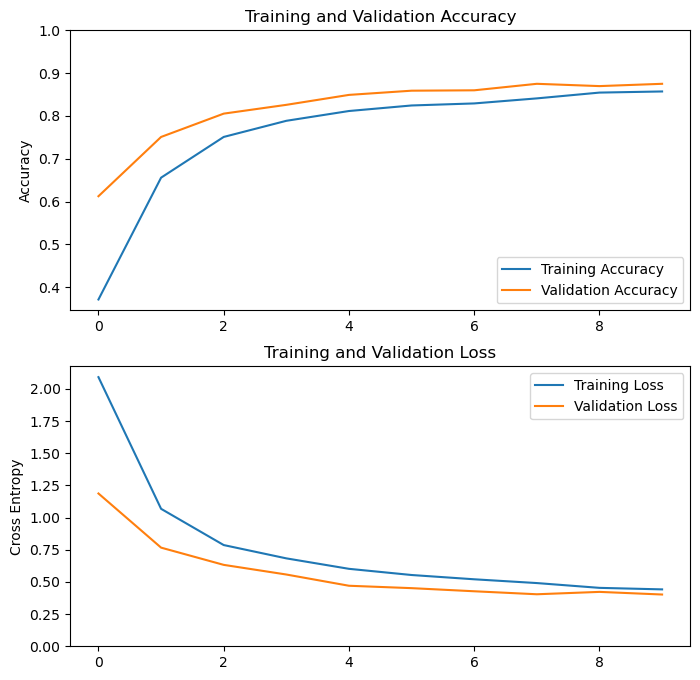

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']



plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')



plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [13]:
# Calculate the Loss and Accuracy on the Validation Data
test_loss, test_acc = model2.evaluate(valid_generator)
print('test accuracy : ', test_acc)

36/36 [==============================] - 8s 215ms/step - loss: 0.4012 - accuracy: 0.8749
test accuracy :  0.8748906254768372


In [14]:
# Check our folder and import the model with best validation accuracy
loaded_best_model = keras.models.load_model("model_ResNet50V2_09-0.87.h5")

# Custom function to load and predict label for the image
def predict(img_rel_path):
    # Import Image from the path with size of (300, 300)
    img = image.load_img(img_rel_path, target_size=(300, 300))
    # Convert Image to a numpy array
    img = image.img_to_array(img, dtype=np.uint8)
    # Scaling the Image Array values between 0 and 1
    img = np.array(img)/255.0

    # Plotting the Loaded Image
    plt.title("Loaded Image")
    plt.axis('off')
    plt.imshow(img.squeeze())
    plt.show()

    # Get the Predicted Label for the loaded Image
    p = loaded_best_model.predict(img[np.newaxis, ...])

    # Label array
    labels = {
                0: 'Bees',
                1: 'Beetles',
                2: 'Butterfly',
                3: 'Cicada',
                4: 'Dragonfly',
                5: 'Grasshopper',
                6: 'Ladybird',
                7: 'Mosquito',
                8: 'Moth',
                9: 'Scorpion',
                10: 'Snail',
                11: 'Spider'
            }
    print("\n\nMaximum Probability: ", np.max(p[0], axis=-1))
    predicted_class = labels[np.argmax(p[0], axis=-1)]
    print("Classified:", predicted_class, "\n\n")

    classes=[]
    prob=[]
    print("\n-------------------Individual Probability--------------------------------\n")

    for i,j in enumerate (p[0],0):
        print(labels[i].upper(),':',round(j*100,2),'%')
        classes.append(labels[i])
        prob.append(round(j*100,2))
        
    def plot_bar_x():
        # this is for plotting purpose
        index = np.arange(len(classes))
        plt.bar(index, prob)
        plt.xlabel('Labels', fontsize=8)
        plt.ylabel('Probability', fontsize=8)
        plt.xticks(index, classes, fontsize=8, rotation=20)
        plt.title('Probability for loaded image')
        plt.show()
    plot_bar_x()

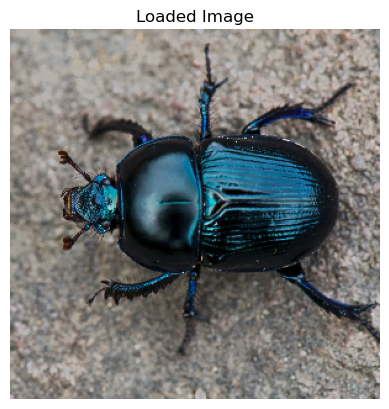

ValueError: in user code:

    File "c:\Users\Youss\anaconda3\envs\TestEnv\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\Youss\anaconda3\envs\TestEnv\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Youss\anaconda3\envs\TestEnv\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\Youss\anaconda3\envs\TestEnv\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "c:\Users\Youss\anaconda3\envs\TestEnv\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\Youss\anaconda3\envs\TestEnv\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 300, 300, 3)


In [15]:
predict("testingImages/beetle.jpg")

In [2]:
def extract_integer_from_string(x):
    y = ""
    for char in x:
        if char.isdigit():
            y += char
    y = int(y)
    return y


x = "i have 12 apples."
y = extract_integer_from_string(x)
print(y)  # Output: 12

12
